In [1]:
# =============================================================================
# MODELO 2: CLASIFICACIÓN MULTICLASE (Niveles de riesgo: Bajo/Medio/Alto/Crítico)
# =============================================================================

# 1. Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto al path
sys.path.append(str(Path.cwd().parent))

# Importar configuración y funciones del proyecto
from src import config
from src.data_prep import load_data, preprocess_pipeline, split_data

# Para el modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [2]:
# =============================================================================
# 2. Carga de datos preprocesados (desde archivos .npy generados en preprocesamiento)
# =============================================================================
# Cargar los arrays guardados
X_train = np.load(config.PROCESSED_DATA_DIR / 'X_train_multi.npy')
X_test = np.load(config.PROCESSED_DATA_DIR / 'X_test_multi.npy')
y_train = np.load(config.PROCESSED_DATA_DIR / 'y_train_multi.npy')
y_test = np.load(config.PROCESSED_DATA_DIR / 'y_test_multi.npy')

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verificar distribución de clases
print("\nDistribución de clases en entrenamiento:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Clase {cls} ({config.RISK_LEVELS[cls]}): {cnt} ({cnt/len(y_train)*100:.2f}%)")

print("\nDistribución de clases en prueba:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Clase {cls} ({config.RISK_LEVELS[cls]}): {cnt} ({cnt/len(y_test)*100:.2f}%)")

X_train shape: (800, 20)
X_test shape: (200, 20)
y_train shape: (800,)
y_test shape: (200,)

Distribución de clases en entrenamiento:
  Clase 0 (Bajo): 139 (17.38%)
  Clase 1 (Medio): 495 (61.88%)
  Clase 2 (Alto): 128 (16.00%)
  Clase 3 (Crítico): 38 (4.75%)

Distribución de clases en prueba:
  Clase 0 (Bajo): 35 (17.50%)
  Clase 1 (Medio): 124 (62.00%)
  Clase 2 (Alto): 32 (16.00%)
  Clase 3 (Crítico): 9 (4.50%)


In [3]:
# =============================================================================
# 3. Convertir etiquetas a one-hot encoding (necesario para categorical_crossentropy)
# =============================================================================
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")
print("\nEjemplo de una etiqueta original y su one-hot:")
print(f"  y_train[0] = {y_train[0]} -> {y_train_cat[0]}")

y_train_cat shape: (800, 4)
y_test_cat shape: (200, 4)

Ejemplo de una etiqueta original y su one-hot:
  y_train[0] = 1 -> [0. 1. 0. 0.]


In [4]:
# =============================================================================
# 4. Construcción del modelo (arquitectura similar a la binaria pero con salida softmax)
# =============================================================================
tf.random.set_seed(config.RANDOM_STATE)

model = keras.Sequential([
    # Capa oculta 1
    layers.Dense(config.MULTICLASS_HIDDEN_LAYERS[0],
                 activation='relu',
                 input_shape=(X_train.shape[1],)),
    layers.Dropout(config.MULTICLASS_DROPOUT_RATE),

    # Capa oculta 2
    layers.Dense(config.MULTICLASS_HIDDEN_LAYERS[1], activation='relu'),
    layers.Dropout(config.MULTICLASS_DROPOUT_RATE),

    # Capa oculta 3
    layers.Dense(config.MULTICLASS_HIDDEN_LAYERS[2], activation='relu'),

    # Capa de salida: 4 neuronas con softmax
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.MULTICLASS_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\ferna\Downloads\Ejercicio ANN\.venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,156 (51.39 KB)

 Trainable params: 13,156 (51.39 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# =============================================================================
# 5. Configuración de Early Stopping y entrenamiento
# =============================================================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=config.EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train_cat,
    epochs=config.MULTICLASS_EPOCHS,
    batch_size=config.MULTICLASS_BATCH_SIZE,
    validation_split=config.VALIDATION_SPLIT,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5031 - loss: 1.3021 - val_accuracy: 0.5750 - val_loss: 1.1586
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6141 - loss: 1.0955 - val_accuracy: 0.5750 - val_loss: 1.0490
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6234 - loss: 1.0144 - val_accuracy: 0.5875 - val_loss: 0.9729
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6359 - loss: 0.9412 - val_accuracy: 0.6250 - val_loss: 0.8711
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6391 - loss: 0.8778 - val_accuracy: 0.6687 - val_loss: 0.7659
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6625 - loss: 0.7974 - val_accuracy: 0.7000 - val_loss: 0.6662
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6922 - loss: 0.7079 - val_accuracy: 0.7312 - val_loss: 0.5846
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6906 - loss: 0.6626 - val_accuracy: 0.

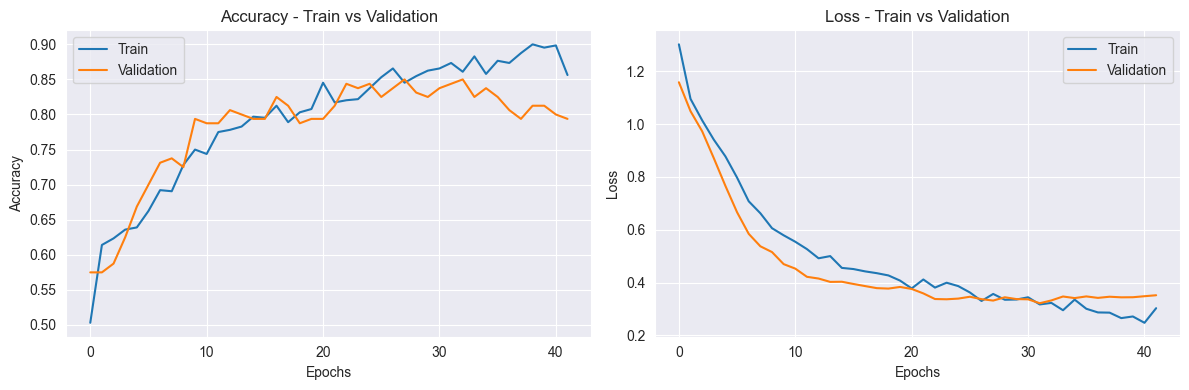

In [6]:
# =============================================================================
# 6. Visualización de curvas de entrenamiento
# =============================================================================
# Precisión
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss - Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Loss en test: 0.3761
Accuracy en test: 0.8450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


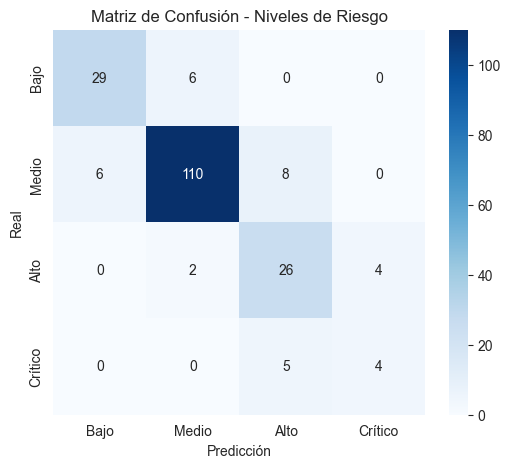


Classification Report:
              precision    recall  f1-score   support

        Bajo       0.83      0.83      0.83        35
       Medio       0.93      0.89      0.91       124
        Alto       0.67      0.81      0.73        32
     Crítico       0.50      0.44      0.47         9

    accuracy                           0.84       200
   macro avg       0.73      0.74      0.74       200
weighted avg       0.85      0.84      0.85       200



In [7]:
# =============================================================================
# 7. Evaluación en el conjunto de prueba
# =============================================================================
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")

# Predicciones
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)   # índice de la clase con mayor probabilidad
y_true = np.argmax(y_test_cat, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=config.RISK_LEVELS,
            yticklabels=config.RISK_LEVELS)
plt.title('Matriz de Confusión - Niveles de Riesgo')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=config.RISK_LEVELS))

In [9]:
# Guardar matriz de confusión multiclase
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=config.RISK_LEVELS, yticklabels=config.RISK_LEVELS)
plt.title('Matriz de Confusión - Modelo Multiclase')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.savefig(config.MODELS_DIR / 'multiclass_confusion_matrix.png', bbox_inches='tight')
plt.close()

# Guardar comparación si existe (opcional)
# ... (código para guardar comparison.csv si lo generaste)

In [8]:
# =============================================================================
# 8. Guardar el modelo entrenado
# =============================================================================
model.save(config.MULTICLASS_MODEL_PATH)
print(f"Modelo guardado en: {config.MULTICLASS_MODEL_PATH}")

# Opcional: guardar también en formato .h5
# model.save(config.MODELS_DIR / 'multiclass_model.h5')

Modelo guardado en: C:\Users\ferna\Music\ProyectoA_RiesgoCrediticio_Oficial\models\multiclass_model.keras
